In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import backbone.Custom as cust
import backbone.VISUAL as viz
import importlib
import matplotlib.pyplot as plt
import AstroMLmod
import numpy as np
import backbone.TwoNN as TwoNN
import time
importlib.reload(cust)


def get_data_loaders(Dir = "some/directory", batch_size = 32):

    #obtain  data from a folder a of images
    dataset = torchvision.datasets.ImageFolder(Dir)
    names = [name[0].split('/')[-1] for name in dataset.imgs]
    transformed_dataset = cust.Custom_labelled(dataset,names =names,resize = 244,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.30)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def galaxyzoo10():
    import h5py
    import numpy as np
    from tensorflow.keras import utils
    
    # To get the images and labels from file
    with h5py.File('Galaxy10_DECals.h5', 'r') as F:
        images = np.array(F['images'])
        labels = np.array(F['ans'])
        ids = np.array(F['ra'])
    
    # To convert the labels to categorical 10 classes
    labels = utils.to_categorical(labels, 10)
    
    # To convert to desirable type
    labels = labels.astype(np.float32)
    images = images.astype(np.float32)

    transformed_dataset = cust.ArrayDataset(images = images,labels =labels,resize = 244,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.30)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_representations(model = None,loader = None, batch_size = 256,patch_level_features = False, epoch = 0,device = "cuda"):
    #initialise global variable
    rep = []
    """
    def hook_fn(module, input, output):
        flat_output = output.view(output.size(0), -1).cpu()
        print(TwoNN.twonn(flat_output,plot = False))
        rep.append(flat_output)
    #model.to(device) model already  on device
    """
    model.eval()
    #hook = model.avgpool.register_forward_hook(hook_fn)
    model.fc = nn.Identity()


    # representations
    rep = []
    twoNNs = []
    with torch.no_grad():
            
        for image,label,name in loader:                                   #name

            image = image.to(device)
            output = model(image).cpu()
            Id = TwoNN.twonn(output,plot = False)[0][0].item()
            twoNNs.append(Id)

            rep.append(output)
    twoNNs = np.array(twoNNs)
    
            
    #hook.remove()
    rep2 = []

    for i in range(len(rep)):
        for j in range(len(rep[i])):
            #images2.append(images[i][j].cpu().numpy()) #Images
            rep_ = rep[i][j].numpy()

            rep2.append(rep_)        #Representations
    print("here")

    #umap = viz.umap(rep2,name = "Features on epoch:"+str(epoch))
    #pca = viz.pca(rep2,variance = 0.95, return_n_components = 20)
    #pca = pca/np.max(pca)
    print("Correlating and plotting")
    #umap = umap/np.max(umap)
    #AstroMLmod.correlate_and_plot(pca,min_dist = 0.5, max_dist =0.8, label = "Correlation on pca epoch:"+str(epoch))
    #viz.pca(rep2,variance = 0.95)
    print(np.mean(twoNNs, axis = 0),np.std(twoNNs,axis = 0, ddof=1))
    
    return np.mean(twoNNs, axis = 0),np.std(twoNNs,axis = 0, ddof=1)

def train_resnet(num_epochs=100, learning_rate=0.0001, Dir ="galaxy_zoo_class_new", batch_size=128, device='cuda'):

    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))
    plt.rcParams.update({'font.size': 20}) 


    train_loader, test_loader = get_data_loaders(Dir = Dir, batch_size = batch_size)
    
    model = models.resnet18(weights = "IMAGENET1K_V1")    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #get_representations(model = model,loader = train_loader, batch_size = batch_size, epoch = 0,device  = device)
    model.fc = nn.Linear(model.fc.in_features, 3) 
    model = model.to(device)

    intrinsic_dimension = []
    validation_accuracy = []
    
    val = evaluate(model, train_loader, test_loader, device)
    Id, std = get_representations(model = model,loader = train_loader, batch_size = batch_size, epoch = 0,device  = device)
    intrinsic_dimension.append(Id)
    validation_accuracy.append(val)

    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, names in train_loader:
            
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        
        val = evaluate(model, train_loader, test_loader, device)  
        Id, std = get_representations(model = model,loader = train_loader, batch_size = batch_size,epoch = epoch, device  = device)
        intrinsic_dimension.append(Id)
        validation_accuracy.append(val)
        model.fc = nn.Linear(512, 3) 
        model.fc = model.fc.to(device)
        plt.plot(intrinsic_dimension)
        plt.plot(validation_accuracy)
        plt.show()
    import pickle

    pkl_filename = "accuaracy.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(intrinsic_dimension,file)
        
    pkl_filename = "validation.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(validation_accuracy,file) 



    #evaluate(model, train_loader, test_loader, device)

def evaluate(model, train_loader,test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    return(100*correct / total)

            
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Train Accuracy: {100 * correct / total:.2f}%')

if __name__ == "__main__":1
 #   train_resnet()

In [33]:
importlib.reload(cust)
load_galaxy10()


/users/koketso/.astroNN/datasets/Galaxy10_DECals.h5 was found!


(array([[[[ 68,  19,  23],
          [ 58,  17,  33],
          [ 40,  16,  40],
          ...,
          [ 51,  46,  43],
          [ 40,  41,  33],
          [ 28,  38,  30]],
 
         [[ 61,  40,  37],
          [ 52,  43,  44],
          [ 29,  39,  41],
          ...,
          [ 28,  30,  42],
          [ 28,  32,  35],
          [ 33,  40,  33]],
 
         [[ 30,  31,  25],
          [ 24,  41,  33],
          [ 15,  45,  33],
          ...,
          [ 21,  35,  48],
          [ 25,  35,  45],
          [ 37,  41,  40]],
 
         ...,
 
         [[ 28,  32,  35],
          [ 27,  31,  32],
          [ 42,  44,  43],
          ...,
          [ 20,  37,  27],
          [ 19,  40,  21],
          [ 27,  50,  24]],
 
         [[ 22,  36,  37],
          [ 19,  29,  30],
          [ 33,  37,  38],
          ...,
          [ 17,  35,  35],
          [ 17,  35,  21],
          [ 26,  45,  17]],
 
         [[ 18,  39,  40],
          [ 14,  28,  29],
          [ 24,  30,  30],
   

In [ ]:
d ~ 18 for pretrained featurse


import torch
import torchvision.models as models

# Load pre-trained ResNet-18
model = models.resnet18(weights="IMAGENET1K_V1")  
# Set to evaluation mode

# Global variable to store the extracted features
extracted_features = None

# Hook function
def hook_fn(module, input, output):
    global extracted_features
    extracted_features = output  # Store the output of the hooked layer

# Register the hook on the adaptive average pooling layer
hook = model.avgpool.register_forward_hook(hook_fn)

# Dummy input
x = torch.randn(1, 3, 224, 224)  # Batch of 1, 3 color channels, 224x224 image

# Forward pass (triggers the hook)
with torch.no_grad():

    _ = model(x)

    
    
    # Unregister the hook after use
    hook.remove()
    
    # Flatten the features
    extracted_features = extracted_features.view(extracted_features.size(0), -1)
    print(extracted_features)

In [ ]:
import pickle
import matplotlib.pyplot as plt

pkl_filename = "accuaracy.csv"
with open(pkl_filename, 'rb') as file:
    i_d= pickle.load(file)
        
pkl_filename = "validation.csv"
with open(pkl_filename, 'rb') as file:
    v_a = pickle.load(file) 


plt.plot(i_d)

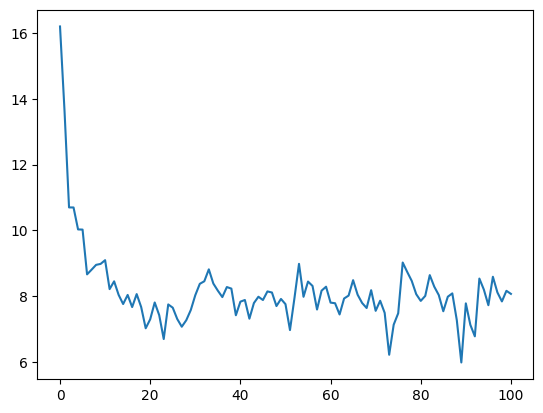

In [23]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    ids = np.array(F['ra'])

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)


NameError: name 'torchvision' is not defined